# Metamers

Metamers are an old concept in the study of perception, dating back to the color-matching experiments in the 18th century that first provided support for the existence of three cone types (though it would be another two hundred years before anatomical evidence was found). These color-matching evidences demonstrated that, by combining three colored lights in different proportions, you could generate a color that humans perceived as identical to any other color, even though their physical spectra were different. Perceptual metamers, then, refer to two images that are physically different but perceived as identical.

For the purposes of `plenoptic`, wherever we say "metamers", we mean "model metamers": images that are physically different but have identical representation for a given model, i.e., that the model "perceives" as identical. Like all synthesis methods, it is model-specific, and one potential experiment is to determine if model metamers can serve as human percpetual metamers, which provides support for the model as an accurate representation of the human visual system.

In the Lab for Computational Vision, this goes back to [Portilla and Simoncelli, 2001](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf), where the authors created a parametric model of textures and synthesized novel images as a way of demonstrating the cases where the model succeeded and failed. In that paper, the model did purport to have anything to do with human vision, and they did not refer to their images as "metamers", that term did not appear until [Freeman and Simoncelli, 2011](https://www.cns.nyu.edu/pub/eero/freeman10-reprint.pdf), where the authors pool the Portilla and Simoncelli texture statistics in windows laid out in a log-polar fashion to generate putative human perceptual metamers.

This notebook demonstrates how to use the `Metamer` class to generate model metamers.

**NOTE**: This will be revamped to feature the Portilla-Simoncelli texture stats once that PR has been merged.

In [1]:
import plenoptic as po
from plenoptic.tools import to_numpy
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our model.

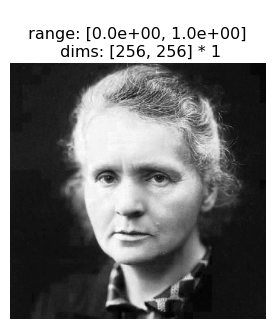

In [2]:
img = po.tools.load_images(['../data/256/curie.pgm'])
po.imshow(img);

For the model, we'll use a simple On-Off model of visual neurons

In [3]:
model = po.simul.OnOff((7, 7))

Like all of our models, when this is called on the image, it returns a 3d or 4d tensor (in this case, 4d). This representation is what the `Metamer` class will try to match. 

In [4]:
print(model(img))

tensor([[[[0.4025, 0.4851, 0.6685,  ..., 0.7740, 0.7702, 0.8194],
          [0.5108, 0.5856, 0.7292,  ..., 0.7519, 0.7994, 0.8431],
          [0.7408, 0.7677, 0.7868,  ..., 0.7268, 0.8530, 0.9048],
          ...,
          [0.6423, 0.6496, 0.7211,  ..., 0.6243, 0.8771, 0.9805],
          [0.8593, 0.8457, 0.8157,  ..., 0.6590, 0.7922, 0.8422],
          [0.9411, 0.9230, 0.8345,  ..., 0.6414, 0.7086, 0.7261]],

         [[1.1070, 0.9575, 0.7185,  ..., 0.6181, 0.6214, 0.5808],
          [0.9177, 0.8144, 0.6582,  ..., 0.6375, 0.5969, 0.5624],
          [0.6473, 0.6233, 0.6070,  ..., 0.6604, 0.5548, 0.5177],
          ...,
          [0.7469, 0.7388, 0.6658,  ..., 0.7674, 0.5372, 0.4694],
          [0.5504, 0.5604, 0.5835,  ..., 0.7287, 0.6026, 0.5629],
          [0.4945, 0.5061, 0.5690,  ..., 0.7479, 0.6778, 0.6611]]]],
       grad_fn=<SoftplusBackward>)


In order to visualize this, we can use the helper function `plot_representation` (see `Display` notebook for more details here). In this case, the representation looks like a single image, and so we plot it as such:

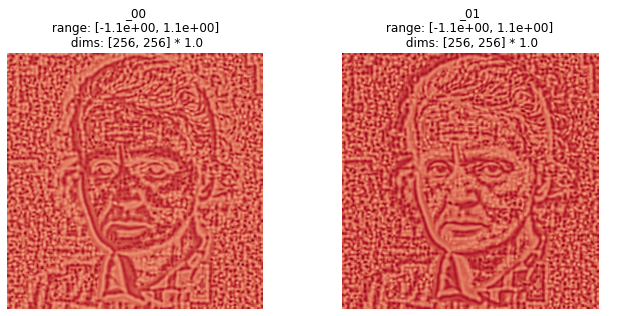

In [5]:
po.tools.display.plot_representation(data=model(img), figsize=(11, 5));

At the simplest, to use `Metamer`, simply initialize it with the target image and the model, then call `.synthesize()`. By setting `store_progress=True`, we update a variety of attributes (all of which start with `saved_`) on each iteration so we can later examine, for example, the synthesized image over time.

In [6]:
met = po.synth.Metamer(img, model)
met.synthesize(store_progress=True, max_iter=50)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.4253, 0.0497, 0.5419,  ..., 0.6442, 0.8689, 0.9491],
          [0.5360, 0.0161, 0.8536,  ..., 0.5008, 0.7505, 0.4311],
          [0.3415, 0.7650, 0.0994,  ..., 0.7011, 0.9949, 0.7599],
          ...,
          [0.1336, 0.6979, 0.5000,  ..., 0.3827, 0.6591, 0.9636],
          [0.9524, 0.9471, 0.7902,  ..., 0.3828, 0.3962, 0.9466],
          [1.0048, 0.9499, 0.7212,  ..., 0.5965, 0.9523, 0.9413]]]],
       requires_grad=True)

We then call the `plot_synthesis_status` function to see how things are doing. The image on the left shows the metamer at this moment, while the center plot shows the loss over time, with the red dot pointing out the current loss, and the rightmost plot shows the representation error. If a model has a `plot_representation` method, this plot can be more informative, but this plot can always be created.

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:960: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


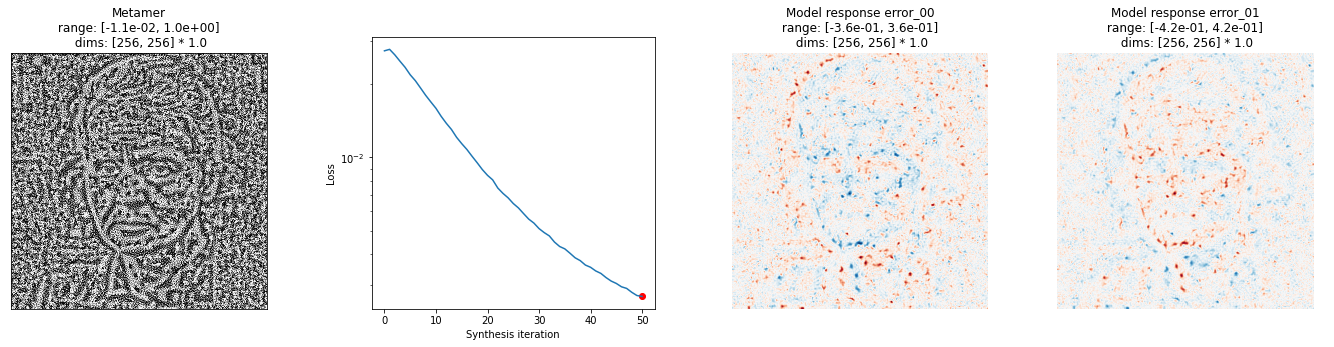

In [7]:
# model response error plot has two subplots, so we increase its relative width
po.synth.metamer.plot_synthesis_status(met, width_ratios={'model_response_error': 2.1});

`plot_synthesis_status()` is a helper function to show all of this at once, but the individual components can be created separately:

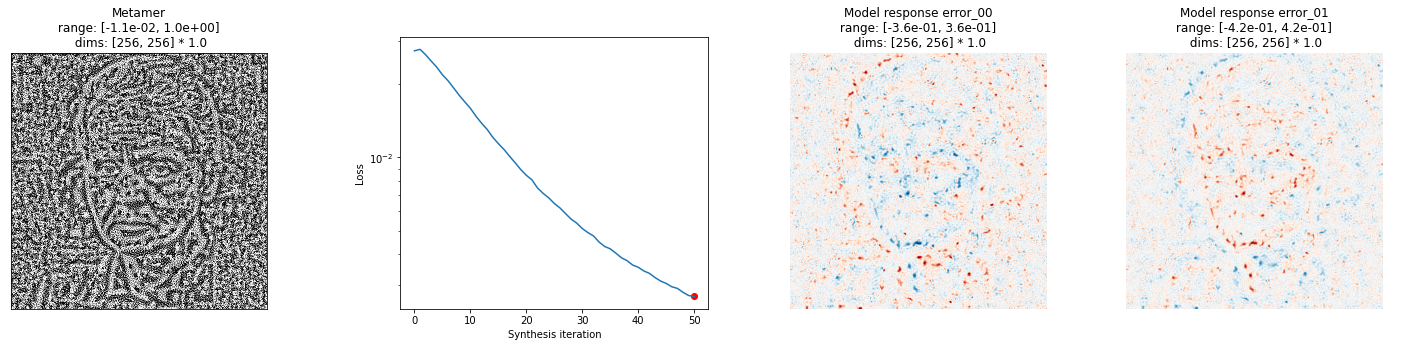

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5), gridspec_kw={'width_ratios': [1, 1, 2]})
po.synth.metamer.display_synthesized_signal(met, ax=axes[0])
po.synth.metamer.plot_loss(met, ax=axes[1])
po.synth.metamer.plot_model_response_error(met, ax=axes[2]);

The loss is decreasing, but clearly there's much more to go. So let's continue.

You can resume synthesis as long as you pass the same argument to ``store_progress`` on each run (several other arguments, such as `optimizer` and `scheduler`, must be None on any run except the first).

Everything that stores the progress of the optimization (``loss``, ``saved_model_response``, ``saved_signal``) will persist between calls and so potentially get very large. 

In [9]:
met.synthesize(store_progress=True, max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[[[0.3497, 0.0522, 0.5157,  ..., 0.6744, 0.7884, 0.9450],
          [0.4248, 0.0716, 0.8269,  ..., 0.5875, 0.7043, 0.4911],
          [0.3076, 0.8020, 0.1135,  ..., 0.9622, 0.9598, 0.9053],
          ...,
          [0.3332, 0.5300, 0.2600,  ..., 0.2620, 0.9362, 0.9694],
          [0.9554, 0.9498, 0.6894,  ..., 0.2785, 0.3249, 0.7195],
          [0.9313, 0.9455, 0.4860,  ..., 0.4086, 0.9456, 0.8970]]]],
       requires_grad=True)

Let's examine the status again. But instead of looking at the most recent status, let's look at 10 from the end:

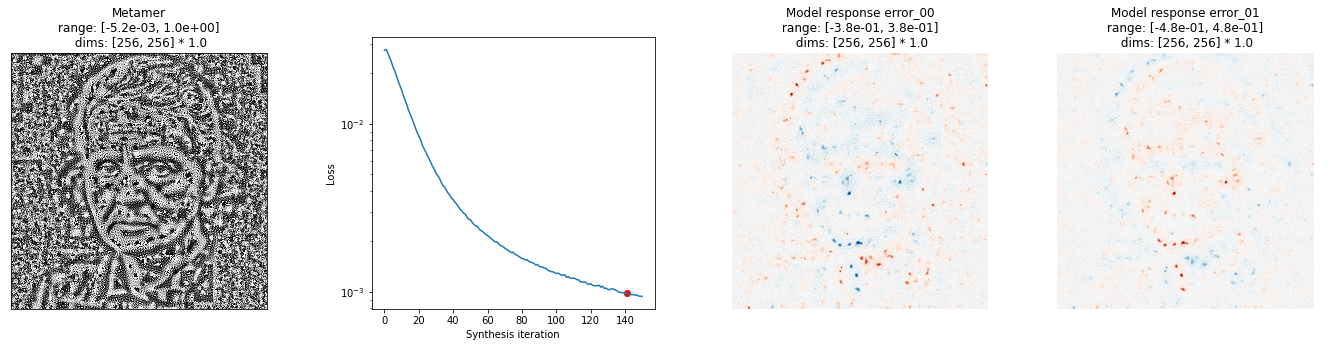

In [10]:
po.synth.metamer.plot_synthesis_status(met, iteration=-10, width_ratios={'model_response_error': 2.1});

Since we have the ability to select which iteration to plot (as long as we've been storing the information), we can create an animation showing the synthesis over time. The `matplotlib.animation` object that gets returned can't be viewed directly, it either has to be converted to html for display in the notebook (using the `convert_anim_to_html` function we provide) or saved as some video format (e.g., `anim.save('test.mp4'`), which requires `ffmpeg` to be installed and on your path.

In [11]:
anim = po.synth.metamer.animate(met, width_ratios={'model_response_error': 2.1})
po.tools.convert_anim_to_html(anim)

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/metamer.py:1489: UserWarning: Looks like model_response is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like model_response is image-like, haven't fully thought out how"


Generally speaking, synthesis will run until you hit `max_iter` iterations. However, synthesis can also stop if it looks like the loss has stopped changing. This behavior is controlled with the `loss_thresh` and `loss_change_iter` arguments: if the loss has changed by less than `loss_thresh` over the past `loss_change_iter` iterations, we stop synthesis.

### Moving between devices

`Metamer` has a `.to()` method for moving the object between devices or dtypes. Call it as you would call any `tensor.to` and it will move over the necessary attributes.

### Saving and loading

Finally, you probably want to save the results of your synthesis. As mentioned above, you can save the synthesis animation, and all of the plots return regular `matplotlib` Figures and can be manipulated as expected. The synthesized image itself is a tensor and can be detached, converted to a numpy array, and saved (either as an image or array) as you'd expect. `po.to_numpy` is a convenience function we provide for stuff like this, which detaches the tensor, sends it to the CPU, and converts it to a numpy array with dtype float32. Note that it doesn't squeeze the tensor, so you may want to do that yourself.

In [12]:
met_image = po.to_numpy(met.synthesized_signal).squeeze()
imageio.imwrite('test.png', met_image)

Lossy conversion from float32 to uint8. Range [-0.008675500750541687, 1.0014065504074097]. Convert image to uint8 prior to saving to suppress this warning.


You can see from the warning that our metamer lies slightly outside the range `[0, 1]`. Metamer's objective function has a quadratic penalty on the synthesized image's range, and the weight on this penalty can be adjusted by changing the value of `range_penalty_lambda` at initialization.

You can also save the entire `Metamer` object. This can be fairly large (depending on how many iterations you ran it for and how frequently you stored progress), but stores all information:

In [13]:
met.save('test.pt')

You can then load it back in using the method `.load()`. Note that you need to first instantiate the `Metamer` object and then call `.load()` -- it must be instantiated with the same image, model, and loss function in order to load it in!

In [14]:
met_copy = po.synth.Metamer(img, model)
# it's modified in place, so this method doesn't return anything
met_copy.load('test.pt')
(met_copy.saved_signal == met.saved_signal).all()

tensor(True)

If you're running synthesis for a long time, you probably want to save periodically in order to avoid losing progress if something goes wrong. To do that, use the `save_progress` argument. If `True`, we save every time we update the saved representation, i.e., every `store_progress` iterations. If an int, we save every `save_progress` iterations. Note that this can't be set if `store_progress=False`.

Be warned that saving can actually take a fair amount of time, so you should only save infrequently, maybe every `max_iter//10` iterations or so.

Because the model itself can be quite large, we do not save it along with the `Metamer` object. This is why you must initialize it before loading from disk.

## Reproducibility

You can set the seed before you call `synthesize()` for reproducibility by using `po.tools.set_seed()`. This will set both the `pytorch` and `numpy` seeds, but note that we can't guarantee complete reproducibility: see [pytroch docs](https://pytorch.org/docs/stable/notes/randomness.html) for some caveats (we currently do not do the stuff described under CuDNN), as well as [this issue](https://github.com/LabForComputationalVision/plenoptic/issues/16) about resuming state after saving.

Also note that pytorch does not guarantee identical results between CPU and GPU, even with the same seed.

## More Advanced Options

The solution found by the end of the [Basic usage section](#Basic-usage) is only one possible metamer. **UNTRUE**: For this model, it was relatively easy to find a decent metamer (as seen by the relatively low loss and representation error), but that's not always the case. Optimization in a high-dimensional space with non-linear models is inherently challenging and so we can't guarantee you'll find a model metamer, but we do provide some tools / extra functionality to help.

### Initialization

By default, the `initial_image` arg when initializing `Metamer` is `None`, in which case we initialize with uniformly-distributed random noise between 0 and 1. If you wish to use some other image for initialization, you can initialize it yourself (it must be the same shape as `target_signal`) and pass it as the `initial_image` arg.
 
### Optimization basics

You can set all the various optimization parameters you'd expect. `synthesize()` has an `optimizer` arg, which accepts a pytorch optimizer. You can therefore initialize your own optimizer after initializing `Metamer` like so

In [15]:
met = po.synth.Metamer(img, model)
opt = torch.optim.Adam([met.synthesized_signal], lr=1, amsgrad=True)
met.synthesize(optimizer=opt)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[[[0.5886, 0.6702, 0.5673,  ..., 0.3086, 0.3659, 0.5134],
          [0.5137, 0.6482, 0.7693,  ..., 0.7248, 0.3788, 0.7612],
          [0.7849, 0.3906, 0.3110,  ..., 0.1326, 0.0441, 0.7504],
          ...,
          [0.4183, 0.5971, 0.5351,  ..., 0.7949, 0.4623, 0.4820],
          [0.3865, 0.3808, 0.4270,  ..., 0.3119, 0.7822, 0.4817],
          [0.4552, 0.2787, 0.3029,  ..., 0.7121, 0.2140, 0.6629]]]],
       requires_grad=True)

`synthesize()` also accepts a `scheduler` argument, so that you can pass a [pytorch scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), which modifies the learning rate during optimization.

### Coarse-to-fine optimization

Some models, such as the Portilla-Simoncelli texture statistics, have a multiscale representation of the image, which can complicate the optimization. It's generally recommended that you normalize the representation (or use a specific loss function) so that the different scales all contribute equally to the representation, but that's out of the scope of this notebook.

We provide the option to use coarse-to-fine optimization, such that you optimize the different scales separately (starting with the coarsest and then moving progressively finer) and then, at the end, optimizing all of them simultaneously. This was first used in Portilla and Simoncelli, 2000, and can help avoid local optima in image space. Unlike everything else described in this notebook, it will not work for all models. There are two specifications the model must meet:

1. It must have a `scales` attribute that gives the scales in the order they should be optimized.
2. Its `forward()` method must accept a `scales` keyword argument, which accpets a list and causes the model to return only the scale(s) included. See `PooledV1.forward()` for an example.

There are two choices for how to handle coarse-to-fine optimization: `'together'` or `'separate'`. In `'together'` (recommended), we start with the coarsest scale and then gradually add each finer scale (thi sis like blurring the objective function and then gradually adding details). In `'separate'`, we compute the gradient with respect to each scale separately (ignoring the others), then with respect to all of them at the end.

In [16]:
# print(v1.scales)
# v1.forward(img, scales=[0])[..., :10]

If this is true, then we can call `synthesize()` with `coarse_to_fine='together'` or `coarse_to_fine='separate'` and it will work through the scales as described above (and will resume correctly if you resume synthesis). Note that this will take a while, as it has to go through each scale. Also note that the progress bar now specifies which scale we're on.

In [17]:
# met = po.synth.Metamer(img, v1)
# met.synthesize(store_progress=True, coarse_to_fine='together', max_iter=100)

In order to control when synthesis considers a scale to be "done" and move on to the next one, you can set the `loss_change_iter` and `loss_change_thresh` arguments: if the scale-specific loss (`current_scale_loss` in the progress bar above) has changed by less than `loss_change_iter` over the past `loss_change_thresh` iterations, we consider that scale to have reached a local optimum and move on to the next.

In [18]:
# met = po.synth.Metamer(img, v1)
# met.synthesize(store_progress=True, coarse_to_fine='together', max_iter=200, loss_change_thresh=.1, loss_change_iter=10)

And we can see these shfits happening in the animation of synthesis:

In [19]:
# po.tools.convert_anim_to_html(met.animate())

There are attributes of `Metamer` that are only used when `coarse_to_fine` is not `False`:
- `scales_loss`: this list contains the scale-specific loss at each iteration (that is, the loss computed on just the scale(s) we're optimizing on that iteration; which we use to determine when to switch scales).
- `scales`: this is a list of the scales in optimization order (i.e., from coarse to fine). The last entry will be `'all'` (since after we've optimized each individual scale, we move on to optimizing all at once). This attribute will be modified by the synthesize() method and is used to track which scale we're currently optimizing (the first one). When we've gone through all the scales present, this will just contain a single value: 'all'.
- `scales_timing`: this is a dictionary whose keys are the values of scales. The values are lists, with 0 through 2 entries: the first entry is the iteration where we started optimizing this scale, the second is when we stopped (thus if it's an empty list, we haven't started optimzing it yet).
- `scales_finished`: this is a list of the scales that we've finished optimizing (in the order we've finished). The union of this and `scales` will be the same as `metamer.model.scales`.

A small wrinkle: if `coarse_to_fine=='together'`, then none of these will ever contain the final, finest scale, since that is equivalent to `'all'`.